# Find feasible bounds for 13C-MFA
The purpose of this notebook is to use FVA to find the bounds of each GSM reaction that are compatible with the measured yields from growth curves


### Load imports

In [24]:
import cobra
import straindesign as sd
import pandas as pd
import sys


source_dir = '../src'
sys.path.append(source_dir)
from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from flux_prediction_scatterplot import flux_prediction_scatterplot
from make_rxn_constraint_string import make_rxn_constraint_string

### Load the genome scale model

In [25]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [26]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x174547b50
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load 13C-MFA data

In [34]:
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_11022023_GR.xlsx', sheet_name='1102 (not corrected)')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head(5)

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,Location on map,glucose_flux,glucose_std_err,glucose_LB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,"(100, 200)",100,3658.800,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,"(250, 400)",NaN,NaN,NaN,...,100,109740.0,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,"(320, 150)",NaN,NaN,NaN,...,100,109740.0,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100,8.443400e-11,100.0000,100.0000,NaN
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,NaN,19.0701,698.003,9.1106,...,-53.4932,58705.0,-53.9377,-43.6888,10.2489,-339.5114,8.630700e+00,-364.6709,-68.7166,295.9543


### Define a flux map generator function

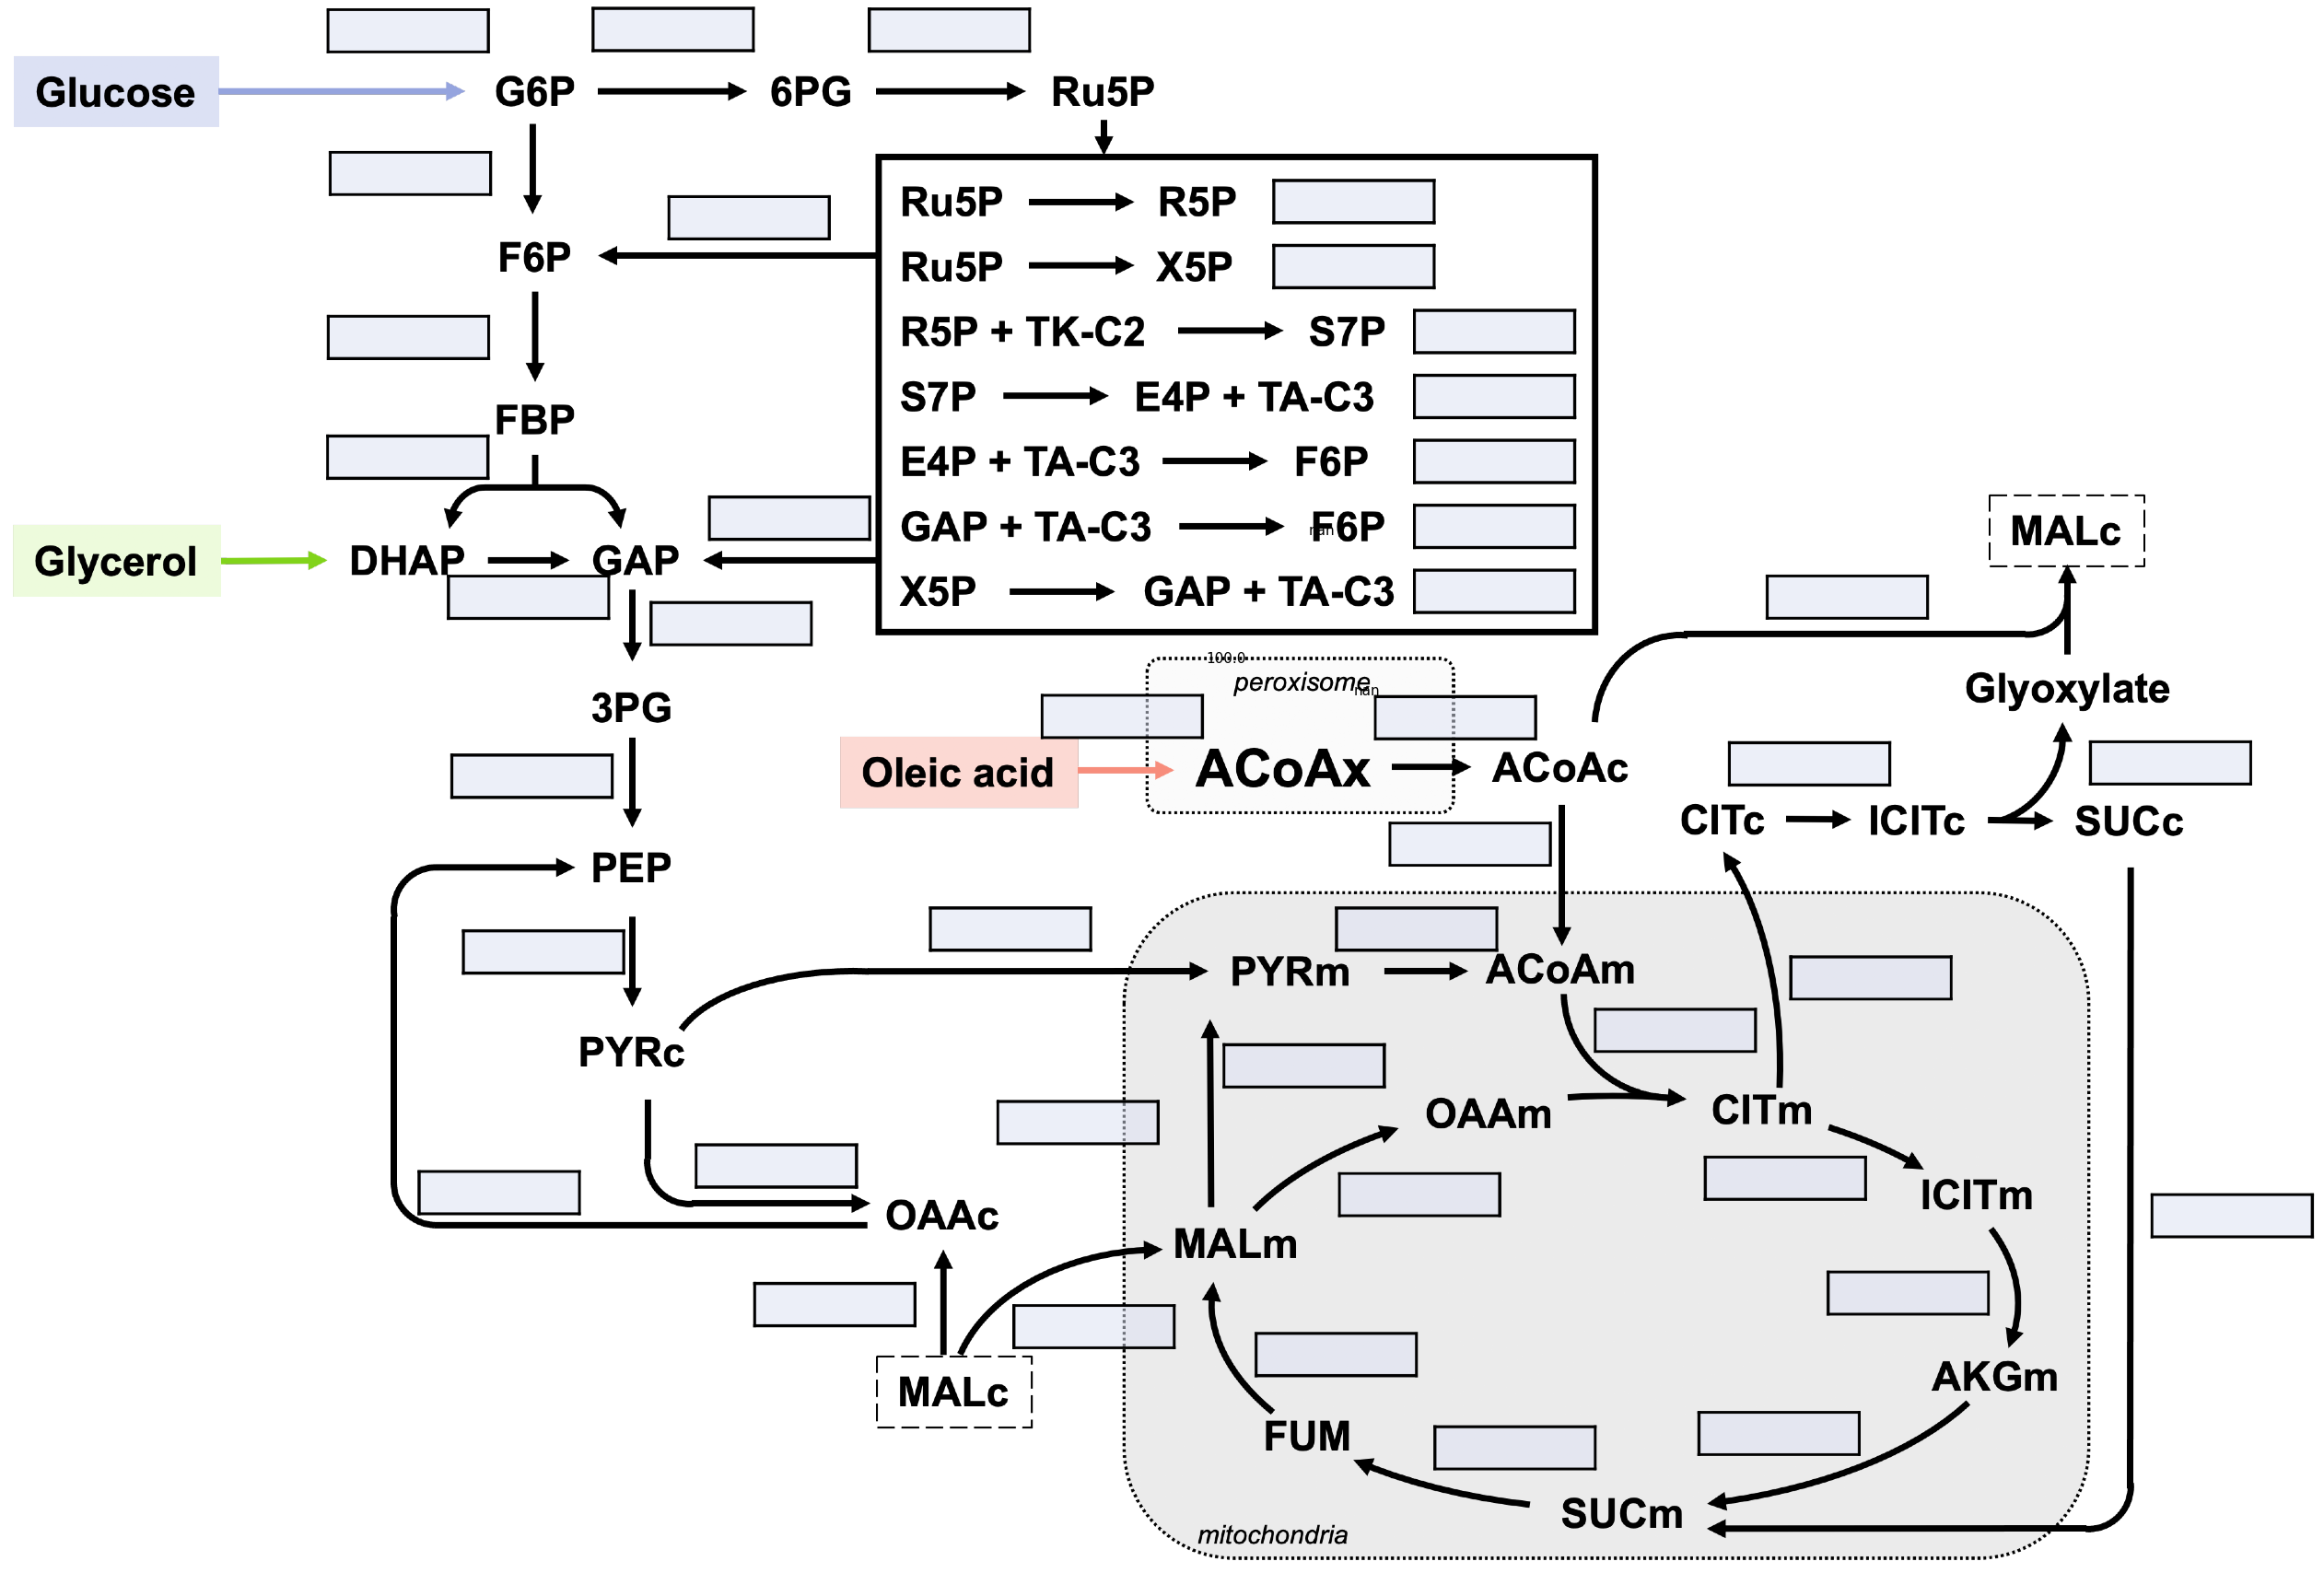

In [35]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox, TextArea)

# This function takes in a flux data frame and column name, and generates a flux map using the flux values in the specified column
def generate_flux_map(
    flux_df=None, 
    flux_column='', 
    file_name='',
):
    # define plot area
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50, facecolor='white')
    
    # load unlabeled image and set as plot background
    unlabeled_image = plt.imread('../figures/templates/flux_map_1_carbon_sources.png')
    imagebox = OffsetImage(unlabeled_image)
    imagebox.image.axes = ax
    xy = (0.5, 0.5)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

    # loop over each reaction in the dataframe
    for _, row in flux_df.iterrows():
        # check that there is a location for the reaction's flux
        if not pd.isnull(row['Location on map']):
            # get the flux value
            flux_value = row[flux_column]

            # get the location of the reaction's flux on the map as a tuple
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            # create a text area with the flux value
            offsetbox = TextArea(
                f'{flux_value:.1f}', 
                textprops=dict(fontsize=40, color='black')
            )
            
            # creates an annotation box, which is a box that can be placed on the plot area.
            ab = AnnotationBbox(
                offsetbox, 
                xy,
                xybox=location_tuple,
                xycoords='data',
                boxcoords="offset points",
                frameon=False
            )

            # add the annotation box to the plot area
            ax.add_artist(ab)

    # ensure that the axes have minimal styles 
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    
    # save and show the plot
    plt.savefig(file_name)
    plt.show()

generate_flux_map(
    flux_df=central_rxn_df, 
    flux_column='glucose_flux', 
    file_name='../figures/test_flux_map.png',
)

### Load growth parameters 

In [5]:
# load the growth parameters from a csv
growth_parameters_df = pd.read_csv('../results/growth_parameters/growth_parameters.csv')
growth_parameters_df.set_index('Unnamed: 0', inplace=True)

growth_parameters_df

,glucose,glycerol,oleic_acid
Unnamed: 0,,,
growth_rate,0.266298,0.358041,0.263841
growth_rate_std,0.003048,0.000861,0.005418
yield_coefficient,0.110433,0.058610,NaN
yield_coefficient_std,0.003913,0.009653,NaN
substrate_uptake_rate,2.414362,6.266590,NaN
substrate_uptake_rate_std,0.088704,0.959634,NaN


### Define a function to run FVA for glucose with measured biomass yield

In [6]:
# this function returns a dataframe with rows for every GSM reaction
# each row has cols for reaction_id, reaction_name, full_reaction, flux, trans_LB, trans_UB, box_LB, box_UB, whisker_LB, and whisker_UB
def get_pfba_fva_df(
        model=None, 
        substrate='', 
        biomass_cutoff=0
):
    # make a copy of the model
    model = model.copy()

    # update the uptake reaction id based on the substrate
    if substrate == 'glucose':
        uptake_reaction_id = 'EX_glc_e'
        biomass_reaction_id = 'biomass_glucose'
        other_biomass_id = 'biomass_oil'
    elif substrate == 'glycerol':
        uptake_reaction_id = 'EX_glyc_e'
        biomass_reaction_id = 'biomass_glucose'
        other_biomass_id = 'biomass_oil'
    else:
        uptake_reaction_id = 'EX_ocdcea_e'
        biomass_reaction_id = 'biomass_oil'
        other_biomass_id = 'biomass_glucose'

    # update the media to minimal medium with the specified sole carbon source
    medium = model.medium
    medium['EX_glc_e'] = 100 if substrate == 'glucose' else 0
    medium['EX_glyc_e'] = 100 if substrate == 'glycerol' else 0
    medium['EX_ocdcea_e'] = 10 if substrate == 'oleic_acid' else 0
    medium['EX_h2o_e'] = 10000
    medium['EX_h_e'] = 10000
    medium['EX_nh4_e'] = 10000
    medium['EX_o2_e'] = 10000
    medium['EX_pi_e'] = 10000
    medium['EX_so4_e'] = 10000
    medium['trehalose_c_tp'] = 0
    model.medium = medium

    # find the optimal solution
    uptake_flux = -10 if substrate == 'oleic_acid' else -100
    biomass_cutoff = 0.1 * biomass_cutoff if substrate == 'oleic_acid' else biomass_cutoff

    # define constraint string
    constraint_string = f'{uptake_reaction_id} = {uptake_flux}, {biomass_reaction_id} >= {biomass_cutoff}, {other_biomass_id} = 0, biomass_C = 0, biomass_N = 0'

    # run pFBA to get the pFBA flux values
    pfba_solution = sd.fba(model, constraints=constraint_string, obj=biomass_reaction_id, obj_sense='maximize', pfba=1)

    print(f'Running pFBA FVA with the constraints: {constraint_string}:')

    # run FVA to the get the pFBA flux ranges
    pfba_fva_solution = sd.fva(
      model, 
      constraints=constraint_string,
    )
    print('ran pfba fva')

    # maybe scale the fluxes to 100 uptake for oleic acid here
    if substrate == 'oleic_acid':
        pfba_fva_solution = pfba_fva_solution * 10

    flux_col_label = f'{substrate}_GSM_flux'
    lb_col_label = f'{substrate}_GSM_LB'
    ub_col_label = f'{substrate}_GSM_UB'

    # make a list of dictionaries with the reaction id, name, flux, and absolute flux
    reactions = []
    for reaction_id, flux in pfba_solution.fluxes.items():
      # add the reaction info to the list of dictionaries
      reactions.append({
        'reaction_id': reaction_id,
        'reaction_name': model.reactions.get_by_id(reaction_id).name,
        'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
        flux_col_label: 10 * flux if substrate == 'oleic_acid' else flux,
        lb_col_label: pfba_fva_solution.loc[reaction_id, 'minimum'],
        ub_col_label: pfba_fva_solution.loc[reaction_id, 'maximum'],
      })

    # make a dataframe from the list of dictionaries
    pfba_df = pd.DataFrame(reactions)

    return pfba_df

# Glucose

### Get yield coefficient

In [7]:
# Get glucose yield coefficient
glucose_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glucose']
print(f'glucose yield coefficient: {glucose_yield_coefficient} g biomass per mmol glucose')


glucose yield coefficient: 0.1104330254973178 g biomass per mmol glucose


### Run FVA with yield coefficient

In [10]:
glucose_gsm_df = get_pfba_fva_df(
    model=model, 
    substrate='glucose', 
    # biomass_cutoff=7
    biomass_cutoff=100*glucose_yield_coefficient
)
glucose_gsm_df

Running pFBA FVA with the constraints: EX_glc_e = -100, biomass_glucose >= 11.04330254973178, biomass_oil = 0, biomass_C = 0, biomass_N = 0:
ran pfba fva


,reaction_id,reaction_name,full_reaction,glucose_GSM_flux,glucose_GSM_LB,glucose_GSM_UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,114.437786
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,4.327208,3.748031,57.941535
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],-1.578903,-24.448072,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,7.603151
...,...,...,...,...,...,...
1345,erythritolT,erythritolT,erythritol[c] <=> erythritol[e],0.000000,0.000000,18.645668
1346,EX_eryth(e),EX_eryth(e),erythritol[e] -->,0.000000,0.000000,18.645668
1347,EX_biom,EX_biom,biomass[c] -->,12.749805,11.043303,12.749805
1348,biomass_glucose,,0.6822317267700153 13BDglcn[c] + 0.55815800338...,12.749805,11.043303,12.749805


### Add glucose FVA data to the central pathway dataframe

In [11]:
full_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
full_central_rxn_df = add_flux_column_to_13c_flux_df(full_central_rxn_df, glucose_gsm_df, 'glucose_GSM_flux')
full_central_rxn_df = add_fva_columns_to_13c_flux_df(full_central_rxn_df, glucose_gsm_df, 'glucose_GSM_LB', 'glucose_GSM_UB')

full_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB,glucose_GSM_flux,glucose_GSM_LB,glucose_GSM_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN,0.0,-18.057244,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0000,2.594100e-10,100.0000,100.0000,0.0000,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.6380,25.0760,...,-15.8469,11.1003,-103.5480,3.191300e+00,-345.1830,-82.7140,262.4690,29.43415,-140.11044,91.399332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,524.8236,8.6023,10.3466,...,5.7743,0.2200,33.3220,1.027000e+00,25.2907,34.7374,9.4467,12.749805,11.043303,12.749805
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,36521.0000,457.2097,813.9649,...,256.9249,44.5736,1670.3000,2.332869e+02,1332.1000,3378.0000,2045.9000,0.0,0.0,228.875572
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,60357.0000,0.0000,50.0149,...,77.1937,24.0062,501.3302,3.195200e+05,0.0000,649.4870,649.4870,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,16486.0000,218.0630,356.4339,...,73.8344,18.7659,677.9611,8.389130e+01,556.3029,1432.6000,876.2971,,,


# Glycerol

### Get yield coefficient

In [12]:
# Get glycerol yield coefficient
glycerol_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glycerol']
print(f'glycerol yield coefficient: {glycerol_yield_coefficient} g biomass per mmol glycerol')


glycerol yield coefficient: 0.0586097809126681 g biomass per mmol glycerol


### Run FVA with yield coefficient

In [16]:
glycerol_gsm_df = get_pfba_fva_df(
    model=model, 
    substrate='glycerol', 
    biomass_cutoff=5
    # biomass_cutoff=100*glycerol_yield_coefficient
)
glycerol_gsm_df

Running pFBA FVA with the constraints: EX_glyc_e = -100, biomass_glucose >= 5, biomass_oil = 0, biomass_C = 0, biomass_N = 0:
ran pfba fva


,reaction_id,reaction_name,full_reaction,glycerol_GSM_flux,glycerol_GSM_LB,glycerol_GSM_UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,13.793681
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,1.761357,1.696970,8.895726
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.000000,-3.277766,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,0.767065
...,...,...,...,...,...,...
1345,erythritolT,erythritolT,erythritol[c] <=> erythritol[e],0.000000,0.000000,2.437031
1346,EX_eryth(e),EX_eryth(e),erythritol[e] -->,0.000000,0.000000,2.437031
1347,EX_biom,EX_biom,biomass[c] -->,5.189712,5.000000,5.189712
1348,biomass_glucose,,0.6822317267700153 13BDglcn[c] + 0.55815800338...,5.189712,5.000000,5.189712


### Add glycerol FVA data to the central pathway dataframe

In [17]:
# add pfba flux column
full_central_rxn_df = add_flux_column_to_13c_flux_df(full_central_rxn_df, glycerol_gsm_df, 'glycerol_GSM_flux')
full_central_rxn_df = add_fva_columns_to_13c_flux_df(full_central_rxn_df, glycerol_gsm_df, 'glycerol_GSM_LB', 'glycerol_GSM_UB')

full_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB,glucose_GSM_flux,glucose_GSM_LB,glucose_GSM_UB,glycerol_GSM_flux,glycerol_GSM_LB,glycerol_GSM_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.0000,100.0000,...,NaN,NaN,NaN,NaN,100.0,100.0,100.0,0.0,0.0,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,-18.057244,0.0,100.0,100.0,100.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,2.594100e-10,100.0000,100.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.6380,25.0760,...,3.191300e+00,-345.1830,-82.7140,262.4690,29.43415,-140.11044,91.399332,-29.786348,-44.017481,-3.894065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,524.8236,8.6023,10.3466,...,1.027000e+00,25.2907,34.7374,9.4467,12.749805,11.043303,12.749805,5.189712,5.0,5.189712
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,36521.0000,457.2097,813.9649,...,2.332869e+02,1332.1000,3378.0000,2045.9000,0.0,0.0,228.875572,0.0,0.0,27.587362
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,60357.0000,0.0000,50.0149,...,3.195200e+05,0.0000,649.4870,649.4870,,,,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,16486.0000,218.0630,356.4339,...,8.389130e+01,556.3029,1432.6000,876.2971,,,,,,


# Oleic Acid

### Get yield coefficient

In [18]:
# Get oleic acid yield coefficient
oleic_acid_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'oleic_acid']
print(f'oleic acid yield coefficient: {oleic_acid_yield_coefficient} g biomass per mmol oleic_acid')


oleic acid yield coefficient: nan g biomass per mmol oleic_acid


### Run FVA with yield coefficient

In [20]:
oleic_acid_gsm_df = get_pfba_fva_df(
    model=model, 
    substrate='oleic_acid', 
    biomass_cutoff=29
    # biomass_cutoff=100*oleic_acid_yield_coefficient
)
oleic_acid_gsm_df

Running pFBA FVA with the constraints: EX_ocdcea_e = -10, biomass_oil >= 2.9000000000000004, biomass_glucose = 0, biomass_C = 0, biomass_N = 0:
ran pfba fva


,reaction_id,reaction_name,full_reaction,oleic_acid_GSM_flux,oleic_acid_GSM_LB,oleic_acid_GSM_UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.0,0.000000,157.094799
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.0,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,0.0,5.818872,54.928641
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.0,-16.850816,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.0,0.000000,6.614518
...,...,...,...,...,...,...
1345,erythritolT,erythritolT,erythritol[c] <=> erythritol[e],0.0,0.000000,15.547526
1346,EX_eryth(e),EX_eryth(e),erythritol[e] -->,0.0,0.000000,15.547526
1347,EX_biom,EX_biom,biomass[c] -->,0.0,29.000000,30.541497
1348,biomass_glucose,,0.6822317267700153 13BDglcn[c] + 0.55815800338...,0.0,0.000000,-0.000000


### Add oleic acid FVA data to the central pathway dataframe

In [21]:
# add pfba flux column
full_central_rxn_df = add_flux_column_to_13c_flux_df(full_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_GSM_flux')
full_central_rxn_df = add_fva_columns_to_13c_flux_df(full_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_GSM_LB', 'oleic_acid_GSM_UB')

full_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_ΔB,glucose_GSM_flux,glucose_GSM_LB,glucose_GSM_UB,glycerol_GSM_flux,glycerol_GSM_LB,glycerol_GSM_UB,oleic_acid_GSM_flux,oleic_acid_GSM_LB,oleic_acid_GSM_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,5590.0000,100.0000,100.0000,...,NaN,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,0.0,-18.057244,0.0,100.0,100.0,100.0,0.0,-17.098754,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,NaN,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,903.3512,7.6380,25.0760,...,262.4690,29.43415,-140.11044,91.399332,-29.786348,-44.017481,-3.894065,0.0,-403.383238,-26.355721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,524.8236,8.6023,10.3466,...,9.4467,12.749805,11.043303,12.749805,5.189712,5.0,5.189712,0.0,29.0,30.541497
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,36521.0000,457.2097,813.9649,...,2045.9000,0.0,0.0,228.875572,0.0,0.0,27.587362,0.0,0.0,314.189597
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,60357.0000,0.0000,50.0149,...,649.4870,,,,,,,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,16486.0000,218.0630,356.4339,...,876.2971,,,,,,,,,


### Save the 13C-MFA bounds from the GSM

In [22]:
# reorder the columns so the the GSM flux columns are next to the 13C flux columns
full_central_rxn_df = full_central_rxn_df[[
    'Unnamed: 0', 'ID', 'Equation', 'reaction_ids', 'pathway', 'compartment', 
    'glucose_flux', 'glucose_LB', 'glucose_UB', 
    'glucose_GSM_flux', 'glucose_GSM_LB', 'glucose_GSM_UB',
    'glycerol_flux', 'glycerol_LB', 'glycerol_UB',
    'glycerol_GSM_flux', 'glycerol_GSM_LB', 'glycerol_GSM_UB',
    'oleic_acid_flux', 'oleic_acid_LB', 'oleic_acid_UB',
    'oleic_acid_GSM_flux', 'oleic_acid_GSM_LB', 'oleic_acid_GSM_UB',


  # 'reaction_ids', 'reaction_names', 'full_reactions', 'glucose_13C_flux', 'glucose_13C_LB', 'glucose_13C_UB', 
  # 'glucose_GSM_flux', 'glucose_GSM_LB', 'glucose_GSM_UB', 'glycerol_13C_flux', 'glycerol_13C_LB', 'glycerol_13C_UB', 
  # 'glycerol_GSM_flux', 'glycerol_GSM_LB', 'glycerol_GSM_UB', 'oleic_acid_13C_flux', 'oleic_acid_13C_LB', 'oleic_acid_13C_UB', 
  # 'oleic_acid_GSM_flux', 'oleic_acid_GSM_LB', 'oleic_acid_GSM_UB'
]]

full_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_LB,glucose_UB,glucose_GSM_flux,...,glycerol_UB,glycerol_GSM_flux,glycerol_GSM_LB,glycerol_GSM_UB,oleic_acid_flux,oleic_acid_LB,oleic_acid_UB,oleic_acid_GSM_flux,oleic_acid_GSM_LB,oleic_acid_GSM_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,100.0000,100.0000,100.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,0.0,...,100.0000,100.0,100.0,100.0,NaN,NaN,NaN,0.0,-17.098754,0.0
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,,...,100.0000,,,,NaN,NaN,NaN,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,0.0,...,NaN,0.0,0.0,0.0,100.0000,100.0000,100.0000,0.0,100.0,100.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,16.1585,7.6380,25.0760,29.43415,...,-15.8469,-29.786348,-44.017481,-3.894065,-103.5480,-345.1830,-82.7140,0.0,-403.383238,-26.355721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80 steph AC,0.294*ALA + 0.174*ARG + 0.196*ASN + 0.196*ASP ...,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,9.3883,8.6023,10.3466,12.749805,...,5.7743,5.189712,5.0,5.189712,33.3220,25.2907,34.7374,0.0,29.0,30.541497
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,653.3256,457.2097,813.9649,0.0,...,256.9249,0.0,0.0,27.587362,1670.3000,1332.1000,3378.0000,0.0,0.0,314.189597
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,15.0638,0.0000,50.0149,,...,77.1937,,,,501.3302,0.0000,649.4870,,,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,294.9322,218.0630,356.4339,,...,73.8344,,,,677.9611,556.3029,1432.6000,,,


In [ ]:
# save the full central rxn df
full_central_rxn_df.to_csv('../results/central_fluxes/mfa_bounds_from_gsm.csv')

### Develop Flux Map Generator Function